In [8]:
import cv2
import pandas as pd
import collections


# Ensure you're working with a copy of the DataFrame slice
def ETGaze2Video(video_path, eye_data, output_video="pilot2/processed/output_with_gaze.mp4"):
    # Now, you can safely modify gaze_data
    # eye_data[['pupilLSensorPosR_X', 'pupilLSensorPosR_Y']] = eye_data[['pupilLSensorPosR_X', 'pupilLSensorPosR_Y']].interpolate()
    eye_data = eye_data.copy()
    eye_data[['pupilLSensorPosR_X', 'pupilLSensorPosR_Y']] = eye_data[['pupilLSensorPosR_X', 'pupilLSensorPosR_Y']].interpolate(method='linear', limit_direction='both')

    # Check for any remaining NaN values after interpolation
    # eye_data[['pupilLSensorPosR_X', 'pupilLSensorPosR_Y']] = eye_data[['pupilLSensorPosR_X', 'pupilLSensorPosR_Y']].fillna(0.5) #########
    eye_data['normalized_Unitytime'] = eye_data.groupby('Scene')['Unitytime'].transform(lambda x: x - x.min())

    # Initialize video capture and writer
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second of the video
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Set target resolution for output video
    # target_width, target_height = 1920, 1080  # Example resolution
    target_width, target_height = 2880, 1600  # Example resolution
    

    # Initialize VideoWriter with target resolution
    out = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'mp4v'), fps, (target_width, target_height))

    # Scale factor for Vive Pro Eye resolution to target video resolution
    # vive_width, vive_height = 2880, 1600  # Original Vive resolution
    # scale_x = target_width / vive_width
    # scale_y = target_height / vive_height

    # Convert normalized Unitytime to frame indices
    maxlen = 30 ##Length of previous data shown
    eye_data['frame_idx'] = (eye_data['normalized_Unitytime'] * fps).astype(int)
    gaze_buffer_L = collections.deque(maxlen=maxlen)
    gaze_buffer_R = collections.deque(maxlen=maxlen)
    gaze_buffer_T = collections.deque(maxlen=maxlen)
    
    # Iterate over each frame of the video
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame {frame_idx}")
            break
        if frame is None:
            print(f"Frame {frame_idx} is None!")
            continue
        # Resize the frame to match the target resolution (if necessary)
        if frame_width != target_width or frame_height != target_height:
            frame = cv2.resize(frame, (target_width, target_height))

        # Retrieve gaze data for the current frame
        gaze_data = eye_data[eye_data['frame_idx'] == frame_idx]

        if not gaze_data.empty:
            # Extract and scale gaze coordinates (already in 2880x1600 space)
            x_L, y_L = gaze_data.mean()[['pupilLSensorPosL_X', 'pupilLSensorPosL_Y']]
            x_R, y_R = gaze_data.mean()[['pupilLSensorPosR_X', 'pupilLSensorPosR_Y']]

            # Convert normalized gaze points to pixel positions
            x_L, y_L = int(x_L * 1440), int(y_L * target_height)  # Left eye (1440x1600)
            x_R, y_R = int(x_R * 1440) + 1440, int(y_R * target_height)  # Right eye (shifted by 1440)
            x_T, y_T = (x_L + x_R) // 2, (y_L + y_R) // 2  # Combined gaze point

            # Append gaze points to buffers
            if 0 <= x_L < target_width and 0 <= y_L < target_height:
                gaze_buffer_L.append((x_L, y_L))
            if 0 <= x_R < target_width and 0 <= y_R < target_height:
                gaze_buffer_R.append((x_R, y_R))
            if 0 <= x_T < target_width and 0 <= y_T < target_height:
                gaze_buffer_T.append((x_T, y_T))

        # Draw gaze points with fading effect
        overlay = frame.copy()
        for i, (gx, gy) in enumerate(gaze_buffer_L):  # Left eye (Red)
            alpha = (i + 1) / 30 * 0.5
            color = (0, 0, int(255 * alpha))
            cv2.circle(overlay, (gx, gy), 5, color, -1)
        for i, (gx, gy) in enumerate(gaze_buffer_R):  # Right eye (Green)
            alpha = (i + 1) / 30 * 0.5
            color = (0, int(255 * alpha), 0)
            cv2.circle(overlay, (gx, gy), 5, color, -1)
        for i, (gx, gy) in enumerate(gaze_buffer_T):  # Combined gaze (Blue)
            alpha = (i + 1) / 30 * 0.5
            color = (int(255 * alpha), 0, 0)
            cv2.circle(overlay, (gx, gy), 5, color, -1)

        # Combine overlay and original frame
        frame = cv2.addWeighted(overlay, 0.5, frame, 0.5, 0)

        # Highlight the latest gaze points
        if gaze_buffer_L:
            cv2.circle(frame, gaze_buffer_L[-1], 7, (0, 0, 255), -1)  # Left eye
        if gaze_buffer_R:
            cv2.circle(frame, gaze_buffer_R[-1], 7, (0, 255, 0), -1)  # Right eye
        if gaze_buffer_T:
            cv2.circle(frame, gaze_buffer_T[-1], 7, (255, 0, 0), -1)  # Combined

        # Write the frame to the output video
        out.write(frame)
        frame_idx += 1

    # Release resources
    cap.release()
    out.release()

In [10]:
# Load video and eye-tracking data
video_path = "pilot2/sangsu/02_ElevatorTest.mp4"
data_path = "pilot2/processed/eyetracker.pkl"
data = pd.read_pickle(data_path)
scenes = ["02_ElevatorTest", "03_Elevator1", "04_Outside", "05_Hallway", "06_Elevator2", "07_Hall"]
# scenes = ["02_ElevatorTest"]

for item in scenes:
    video_path = f"pilot2/raw/sangsu/{item}.mp4"
    eye_data = data[data["Scene"]==pd.to_numeric(item[1])]
    output_video = f"pilot2/processed/{item}_newgaze.mp4"
    ETGaze2Video(video_path, eye_data, output_video)

Failed to read frame 1617
Failed to read frame 5922


KeyboardInterrupt: 

In [13]:
scenes = ["02_ElevatorTest", "03_Elevator1", "04_Outside", "05_Hallway", "06_Elevator2", "07_Hall"]
data_path = "pilot2/processed/eyetracker.pkl"
data = pd.read_pickle(data_path)
eye_data = data[data['Scene']==2].copy()


In [21]:
!pip install ultralytics

     ------------------------------------- 898.7/898.7 kB 28.7 MB/s eta 0:00:00


In [24]:
import torch
print("GPU Available:", torch.cuda.is_available())

GPU Available: True


In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
import torch
from ultralytics import YOLO  # Example with YOLOv8
import numpy as np
# Load SAM
model_type = "vit_b"
sam_checkpoint = "sam_vit_b.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

# Load YOLO (Human detection model)
yolo = YOLO("yolov8n.pt")  # Pre-trained YOLOv8 model
yolo.to("cuda" if torch.cuda.is_available() else "cpu")  # Load model to GPU
# Video paths
video_path = "pilot2/sangsu/03_Elevator1.mp4"
# eye_data_path = "pilot2/processed/eyetracker.pkl"
# eye_data = pd.read_pickle(eye_data_path)
output_video = "pilot2/processed/output_with_humans.mp4"

# Open video
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*"mp4v"), fps, (frame_width, frame_height))

# Color for human masks
human_color = (0, 255, 255, 127)  # Yellow (semi-transparent)

def add_transparent_mask(image, mask, color):
    """Overlay a transparent mask on the image."""
    overlay = image.copy()
    overlay[mask] = color[:3]  # RGB values
    return cv2.addWeighted(overlay, color[3] / 255, image, 1 - color[3] / 255, 0)

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect humans using YOLO
    results = yolo(frame)  # YOLO inference
    human_boxes = []

    # Extract detections from results
    for result in results:
        # Iterate through each detection
        for detection in result.boxes:  # Access bounding boxes
            cls = int(detection.cls)  # Class label
            conf = detection.conf  # Confidence score
            if cls == 0 and conf > 0.5:  # Class 0 corresponds to "person"
                x_min, y_min, x_max, y_max = map(int, detection.xyxy[0])  # Bounding box coordinates
                human_boxes.append([x_min, y_min, x_max, y_max])

    # Generate fine masks for humans using SAM
    for box in human_boxes:
        x_min, y_min, x_max, y_max = box
        sam_input = frame[y_min:y_max, x_min:x_max]  # Crop the human region
        masks = mask_generator.generate(sam_input)

        # Apply the mask (assume the largest mask is the human)
        if masks:
            largest_mask = max(masks, key=lambda m: m['area'])
            full_mask = np.zeros(frame.shape[:2], dtype=bool)
            full_mask[y_min:y_max, x_min:x_max] = largest_mask['segmentation']
            frame = add_transparent_mask(frame, full_mask, human_color)

    # Write the frame
    out.write(frame)

cap.release()
out.release()


0: 384x640 (no detections), 4.8ms
Speed: 3.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 chair, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.8ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3.0ms
Speed: 2.9ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4.0ms
Speed: 3.0ms preprocess, 4.0ms inference, 1.0ms postproc

In [ ]:
import os
import cv2
import torch
from segment_anything import SamPredictor, sam_model_registry
import pandas as pd
import matplotlib.pyplot as plt

# 1. Download and Load SAM Model
sam_checkpoint = "./sam_vit_b.pth"  # Replace with appropriate model path
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)

# 2. Process Video Frames
video_path = "pilot2/sangsu/02_ElevatorTest.mp4"
eye_data_path = "pilot2/processed/eyetracker.pkl"
eye_data = pd.read_pickle(eye_data_path)
eye_data['frame_idx'] = eye_data['frame_idx'].astype(int)

cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# 3. Segment and Match Gaze Points
gaze_summary = {"agent": 0, "others": 0}
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Resize and preprocess for SAM
    input_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    predictor.set_image(input_frame)
    masks, _, _ = predictor.predict(box=None, multimask_output=True)  # Modify for AOI detection
    
    # Example: Define AOIs (simplify as agent/other for illustration)
    agent_mask = masks[0]  # Assume the first mask corresponds to the agent
    other_mask = masks[1]  # Adjust logic based on segmentation results
    
    # Match gaze points to AOIs
    gaze_data = eye_data[eye_data['frame_idx'] == frame_idx]
    for _, gaze_point in gaze_data.iterrows():
        x, y = int((gaze_point['pupilLSensorPosL_X']+gaze_point['pupilLSensorPosR_X'])/2), 
        int((gaze_point['pupilLSensorPosL_Y']+gaze_point['pupilLSensorPosR_Y'])/2)
        if agent_mask[y, x]:
            gaze_summary["agent"] += 1 / fps  # Increment time spent in AOI
        elif other_mask[y, x]:
            gaze_summary["others"] += 1 / fps
    
    frame_idx += 1

cap.release()

# 4. Summarize and Visualize Gaze Statistics
summary_df = pd.DataFrame([gaze_summary])
print(summary_df)

# Plotting
plt.bar(gaze_summary.keys(), gaze_summary.values(), color=['blue', 'green'])
plt.title("Gaze Time by AOI")
plt.ylabel("Time (seconds)")
plt.show()

ModuleNotFoundError: No module named 'segment_anything'

In [28]:
gaze_data[['pupilLSensorPosL_X','pupilLSensorPosL_Y']]

,pupilLSensorPosL_X,pupilLSensorPosL_Y
1970-01-01 00:00:59.194,0.390934,0.382660
1970-01-01 00:00:59.196,0.391134,0.382301
1970-01-01 00:00:59.198,0.391334,0.381942
1970-01-01 00:00:59.200,0.391534,0.381582
1970-01-01 00:00:59.202,0.391597,0.381212
1970-01-01 00:00:59.204,0.391360,0.380817
1970-01-01 00:00:59.206,0.391124,0.380422
1970-01-01 00:00:59.208,0.390887,0.380027
1970-01-01 00:00:59.210,0.390650,0.379632
1970-01-01 00:00:59.212,0.390762,0.379178


In [ ]:
x, y =gaze_data[['pupilLSensorPosR_X', 'pupilLSensorPosR_Y']].mean()
print(x,y)


0.4167138636112213 0.4082764983177185


In [11]:
eye_data.columns

Index(['Scene', 'Unitytime', 'validL', 'validR', 'gazeoriginL_X',
       'gazeoriginL_Y', 'gazeoriginL_Z', 'gazeoriginR_X', 'gazeoriginR_Y',
       'gazeoriginR_Z', 'gazeL_X', 'gazeL_Y', 'gazeL_Z', 'gazeR_X', 'gazeR_Y',
       'gazeR_Z', 'pupilL', 'pupilR', 'eye_opennessL', 'eye_opennessR',
       'pupilLSensorPosL_X', 'pupilLSensorPosL_Y', 'pupilLSensorPosL_Z',
       'pupilLSensorPosR_X', 'pupilLSensorPosR_Y', 'pupilLSensorPosR_Z',
       'convergence_distance_mm', 'convergence_distance_validity',
       'normalized_Unitytime', 'frame_idx'],
      dtype='object')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import os
import pyxdf
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import cv2

def normalize_data(data):
    """Normalize data while handling edge cases."""
    data_range = np.max(data, axis=0) - np.min(data, axis=0)
    # Prevent division by zero
    data_range[data_range == 0] = 1
    return (data - np.min(data, axis=0)) / data_range

def check_ffmpeg():
    """Check if ffmpeg is available."""
    try:
        import shutil
        if shutil.which("ffmpeg") is None:
            print("Warning: ffmpeg not found. Using PillowWriter instead.")
            return False
        return True
    except Exception as e:
        print(f"Error checking ffmpeg: {e}")
        return False

def validate_data(data):
    """Ensure data is valid for processing."""
    if not isinstance(data, np.ndarray):
        raise ValueError("Input data must be a NumPy array.")
    if data.size == 0:
        raise ValueError("Input data is empty.")
    if np.isnan(data).any():
        raise ValueError("Input data contains NaN values.")

def create_lip_tracking_video(lip_data, output_file="lip_tracking.mp4"):
    """
    Create a video visualizing lip tracking data.
    
    Parameters:
    - lip_data: np.ndarray
        Lip tracking data with shape (frames, features).
    - output_file: str
        Path to save the video.
    """
    try:
        # Validate lip data
        validate_data(lip_data)
        
        # Normalize the lip data
        lip_data_normalized = normalize_data(lip_data)

        # Check if ffmpeg is available
        use_ffmpeg = check_ffmpeg()

        # Set up the figure
        fig, ax = plt.subplots()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        scatter = ax.scatter([], [])

        def update(frame):
            # Update scatter plot with the current frame
            scatter.set_offsets(lip_data_normalized[frame].reshape(-1, 2))
            return scatter,

        # Create animation
        ani = animation.FuncAnimation(
            fig, update, frames=len(lip_data_normalized), blit=True
        )

        # Choose writer
        if use_ffmpeg:
            writer = animation.FFMpegWriter(fps=30)
        else:
            writer = PillowWriter(fps=30)

        # Save animation
        ani.save(output_file, writer=writer)
        print(f"Video saved to {output_file}")
    
    except ValueError as e:
        print(f"ValueError: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
    finally:
        plt.close(fig)

# Example usage
if __name__ == "__main__":
    # Simulate some lip data for testing
    # frames = 100
    # features = 2  # X, Y for simplicity
    # lip_data = np.random.rand(frames, features)
    file_path = './pilot2/raw/sangsu/sangsu_VR.xdf'
    streams, header = pyxdf.load_xdf(file_path)

    # Test the function
    create_lip_tracking_video(lip_data)

### Face Tracking

Stream 1: Calculated effective sampling rate 88.5949 Hz is different from specified rate 50.0000 Hz.
Stream 2: Calculated effective sampling rate 104.0061 Hz is different from specified rate 60.0000 Hz.
Stream 3: Calculated effective sampling rate 104.0071 Hz is different from specified rate 250.0000 Hz.
C:\Users\Jiyoon\AppData\Local\Temp/ipykernel_33856/887015895.py:26: RuntimeWarning: invalid value encountered in true_divide
  lip_data_normalized = (lip_data - np.min(lip_data, axis=0)) / (np.max(lip_data, axis=0) - np.min(lip_data, axis=0))
MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

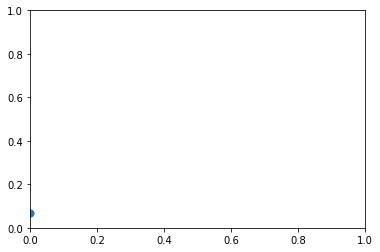

In [1]:
import pyxdf
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import cv2

# Load the .xdf file
file_path = './pilot2/raw/sangsu/sangsu_VR.xdf'
streams, header = pyxdf.load_xdf(file_path)

# Find the stream containing lip tracking data
lip_stream = None
for stream in streams:
    if "lip" in stream['info']['name'][0].lower():  # Assumes "lip" is in the name
        lip_stream = stream
        break

if not lip_stream:
    raise ValueError("No stream containing 'lip' data found in the .xdf file.")

# Extract lip tracking data (e.g., x, y coordinates)
timestamps = np.array(lip_stream['time_stamps'])
lip_data = np.array(lip_stream['time_series'])  # Assuming 2D (x, y) or 3D (x, y, z) data

# Normalize data for visualization
lip_data_normalized = (lip_data - np.min(lip_data, axis=0)) / (np.max(lip_data, axis=0) - np.min(lip_data, axis=0))

# Create a real-time animation
fig, ax = plt.subplots()
scat = ax.scatter([], [], s=50)

def init():
    ax.set_xlim(0, 1)  # Normalized range for x
    ax.set_ylim(0, 1)  # Normalized range for y
    return scat,

def update(frame):
    x, y = lip_data_normalized[frame, :2]  # Extract x, y for the current frame
    scat.set_offsets([x, y])
    return scat,

ani = FuncAnimation(fig, update, frames=len(lip_data_normalized), init_func=init, interval=30, blit=True)

# Save animation as video
ani.save("./pilot2/processed/lip_tracking.mp4", writer='ffmpeg', fps=30)
plt.show()